<a href="https://www.kaggle.com/code/vincentokumu/dry-eye-disease-modeling?scriptVersionId=224293384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [2]:
#Importing data
data = pd.read_csv(r"/kaggle/input/dry-eye-disease/Dry_Eye_Dataset.csv") #reads in data
data.head() #calls glimpse of data frame


,Gender,Age,Sleep duration,Sleep quality,Stress level,Blood pressure,Heart rate,Daily steps,Physical activity,Height,...,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease
0,F,24,9.5,2,1,137/89,67,3000,31,161,...,N,Y,Y,N,8.7,N,Y,Y,N,Y
1,M,39,9.6,2,3,108/64,60,12000,74,164,...,N,Y,Y,N,9.6,Y,N,N,Y,Y
2,F,45,5.4,1,5,134/81,95,12000,93,179,...,N,N,N,Y,4.0,N,Y,N,N,N
3,F,45,5.4,4,5,110/90,78,19000,32,160,...,N,Y,N,N,7.6,N,Y,N,Y,N
4,F,42,5.7,3,2,99/67,72,4000,173,179,...,N,Y,N,N,3.5,N,Y,Y,N,Y


In [3]:
#Checking for normality

import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson

# Select only numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Initialize a DataFrame to store results
results = []

for col in numerical_cols:
    try:
        sample_size = len(data[col].dropna())

        if sample_size <= 5000:
            # Use Shapiro-Wilk Test for small samples
            stat, p = shapiro(data[col].dropna())
            test_name = "Shapiro-Wilk"
        else:
            # Use D’Agostino and Pearson’s Test for large samples
            stat, p = normaltest(data[col].dropna())
            test_name = "D'Agostino-Pearson"

        # Store results in a list
        results.append([col, test_name, f"{stat:.4f}", f"{p:.4f}"])
        
    except Exception as e:
        print(f"Error processing {col}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Variable", "Test", "Statistic", "p-value"])

# Pivot table for better display
pivot_table = results_df.pivot(index="Variable", columns="Test", values=["Statistic", "p-value"])

# Fix column formatting
pivot_table.columns = [f"{stat} - {test}" for stat, test in pivot_table.columns]
print(pivot_table)
 

                    Statistic - D'Agostino-Pearson  \
Variable                                             
Age                                     17964.8260   
Average screen time                     18144.4625   
Daily steps                             17409.6397   
Heart rate                              16940.7475   
Height                                  19561.5822   
Physical activity                       17039.0086   
Sleep duration                          16866.9405   
Sleep quality                           68041.1982   
Stress level                            52381.5147   
Weight                                  19114.6235   

                    p-value - D'Agostino-Pearson  
Variable                                          
Age                                       0.0000  
Average screen time                       0.0000  
Daily steps                               0.0000  
Heart rate                                0.0000  
Height                                    0.0

In [4]:
# Convert DED variable from string to numeric, 
# Converts 'Y' to 1 and 'N' to 0

data['Dry Eye Disease'] = data['Dry Eye Disease'].map({'Y': 1, 'N': 0})

# View distribution
print(data['Dry Eye Disease'].value_counts())
print(data['Dry Eye Disease'].value_counts(normalize=True) * 100)

Dry Eye Disease
1    13037
0     6963
Name: count, dtype: int64
Dry Eye Disease
1    65.185
0    34.815
Name: proportion, dtype: float64


In [5]:
# Calculating Prevalence by Age Category
# Defining Age Categories

min_age = data['Age'].min() # calls the minimum age
max_age = data['Age'].max() # calls maximum age

print(f"Minimum age: {min_age}")
print(f"Maximum age: {max_age}")

bins = [18, 23, 28, 33, 38, 43, 48]  # sets the starting ages for each age group 
labels = ['18-22', '23-27', '28-32', '33-37', '38-42', '43+'] #labels each age category
data['age_category'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

prevalence_age = data.groupby('age_category', observed=False)['Dry Eye Disease'].mean() * 100  # Prevalence calculated in percentage
print("\nPrevalence of Dry Eye Disease by Age Category:\n", prevalence_age)


Minimum age: 18
Maximum age: 45

Prevalence of Dry Eye Disease by Age Category:
 age_category
18-22    65.745554
23-27    64.540017
28-32    63.881996
33-37    65.142535
38-42    65.891693
43+      66.401497
Name: Dry Eye Disease, dtype: float64


In [6]:
# Calculating Prevalence by Gender

prevalence_gender = data.groupby('Gender')['Dry Eye Disease'].mean() * 100  # Prevalence calculated in percentage
print("Prevalence of Dry Eye Disease by Gender:\n", prevalence_gender)

Prevalence of Dry Eye Disease by Gender:
 Gender
F    65.964701
M    64.409653
Name: Dry Eye Disease, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


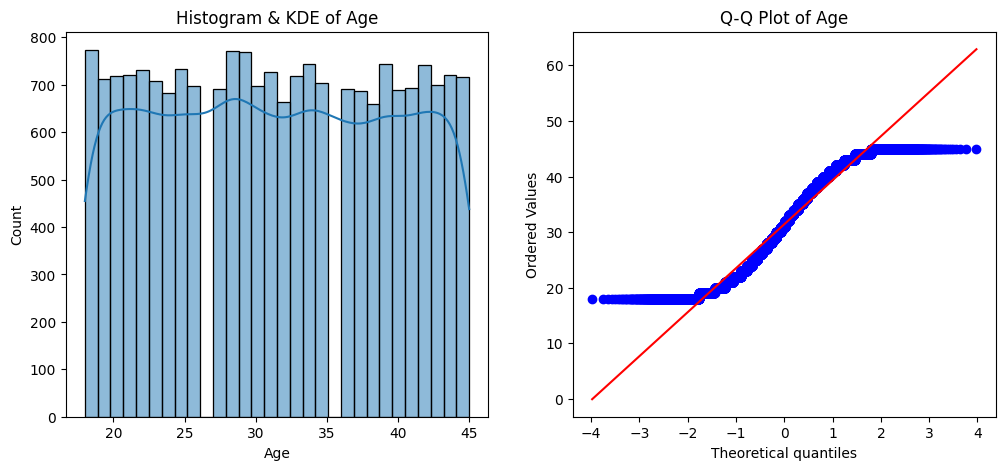

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


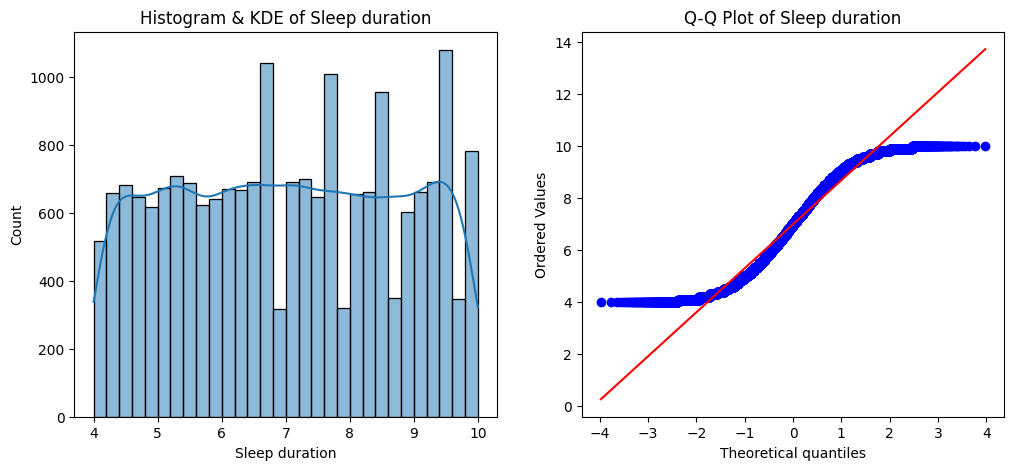

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


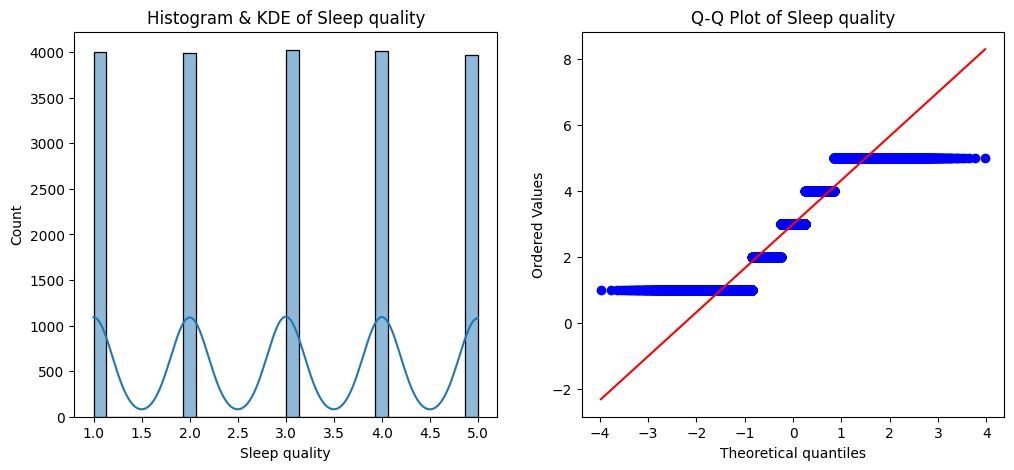

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


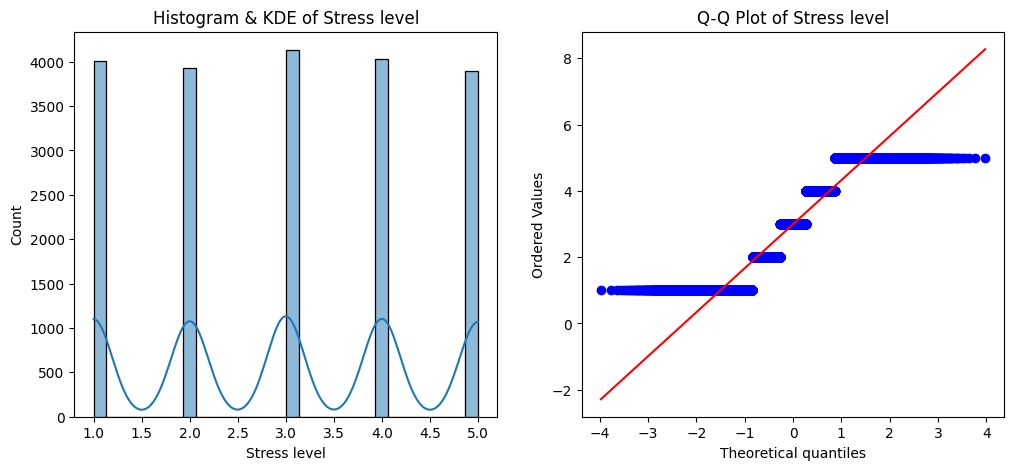

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


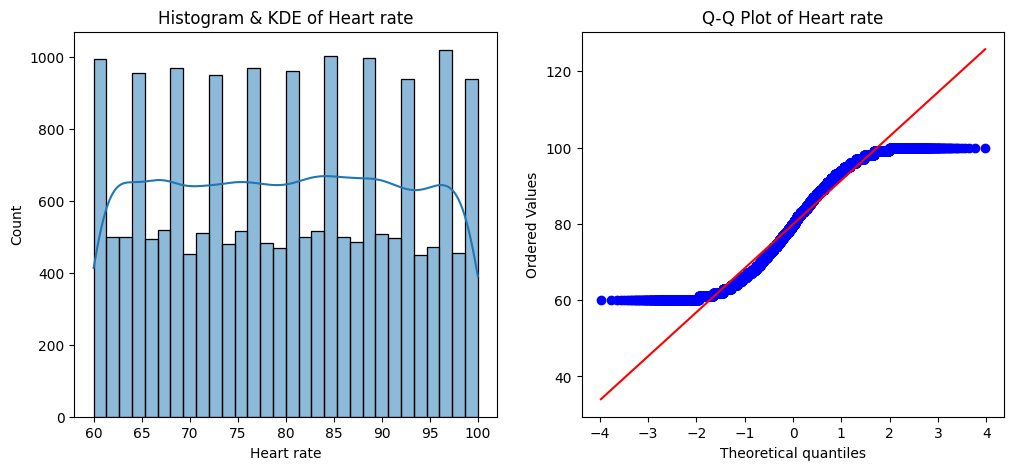

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


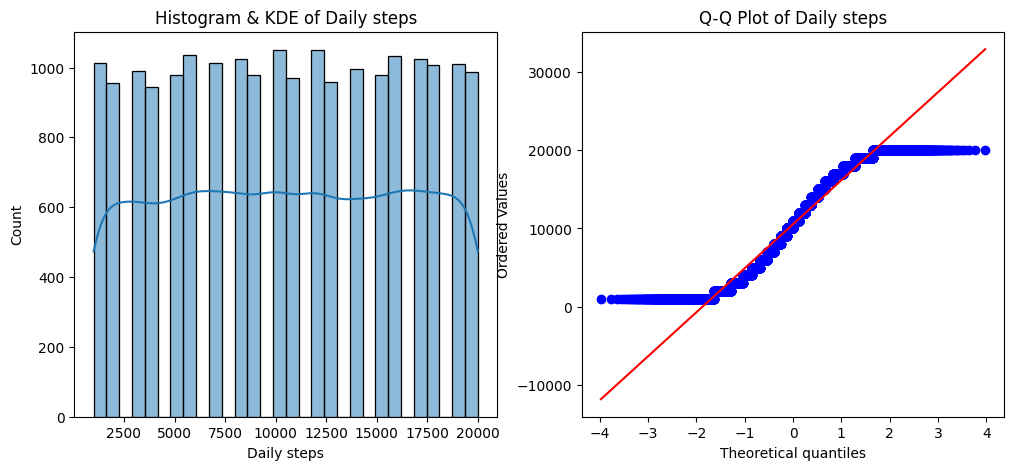

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


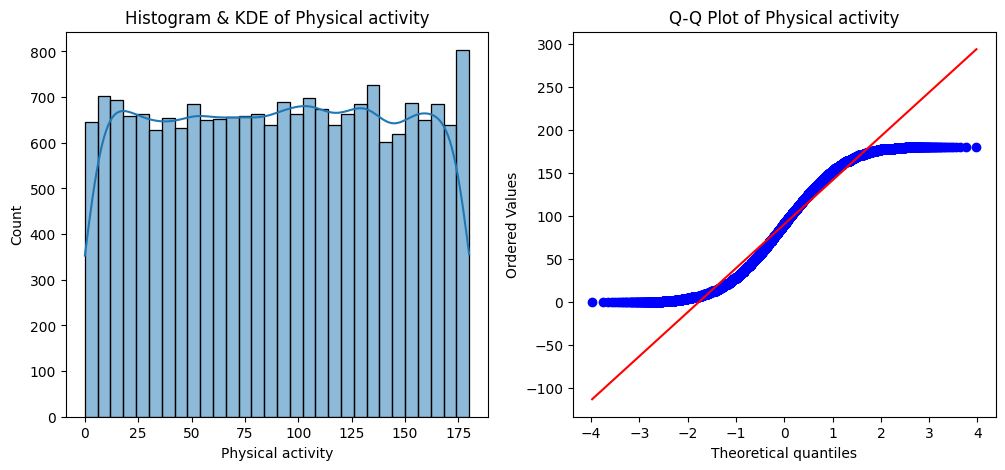

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


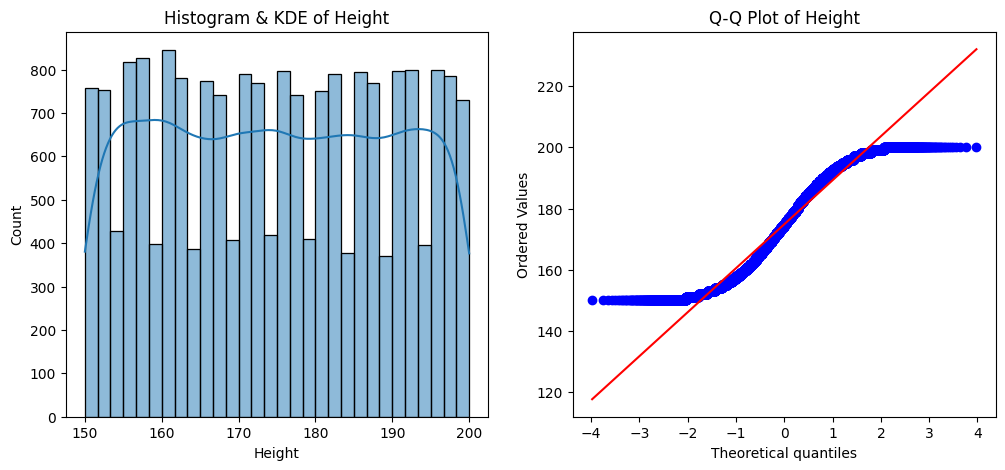

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


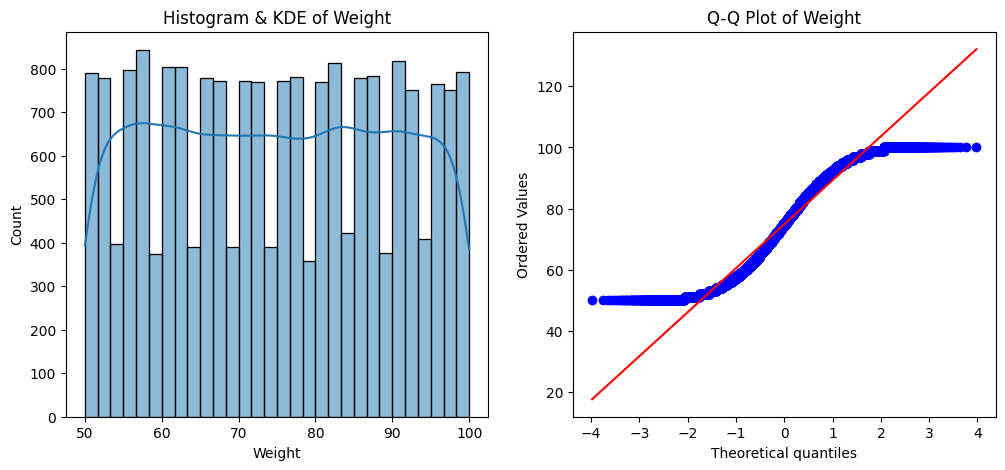

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


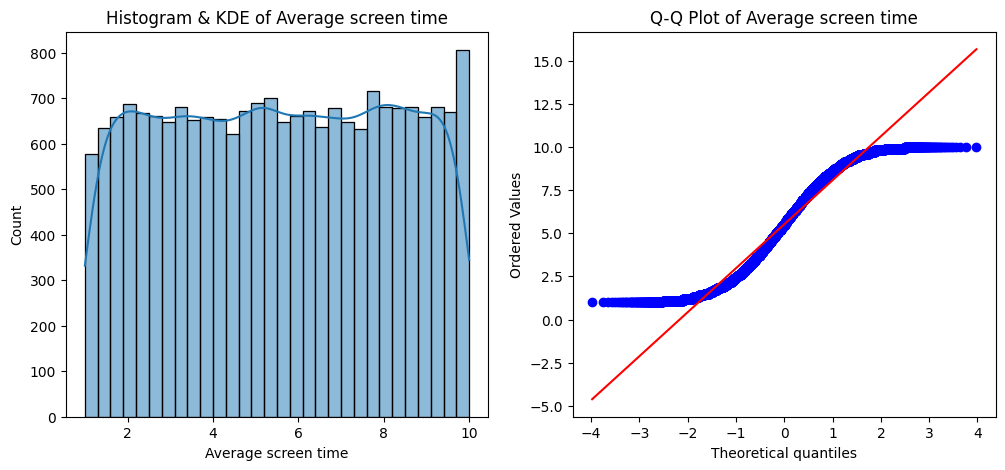

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
for col in numerical_cols:
    plt.figure(figsize=(12,5))

    #Histogram and KDE
    plt.subplot(1,2,1)
    sns.histplot(data[col].dropna(),kde=True, bins=30)
    plt.title(f"Histogram & KDE of {col}")

    # Q-Q Plot
    plt.subplot(1,2,2)
    stats.probplot(data[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")

    plt.show()
    